In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.fft import fft,fftfreq
import os
from PyEMD import EMD
from vmdpy import VMD
import scipy.signal

In [3]:

dataset_path = f"/run/media/daevinci/Data/DATASET_2"

subject_dirs = os.listdir(dataset_path)

bvp_repo = []
for sub in subject_dirs:
    path = os.path.join(dataset_path, sub, "Label/BVP.mat")
    print(path)
    bvp = scipy.io.loadmat(path)
    bvp_repo.append(bvp['BVP'].squeeze())
    
print(bvp_repo[0].shape)

# Number of sample points
N = bvp_repo[0].shape[0]
fs = 60
# sample spacing
T = 1.0 / 60.0

/run/media/daevinci/Data/DATASET_2/subject31/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject32/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject33/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject34/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject35/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject36/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject37/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject38/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject39/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject4/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject40/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject41/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject42/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject43/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject44/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject45/Label/BVP.mat
/run/media/daevinci/Data/DATASET_2/subject46/Label/BVP.ma

### Derivatives of the signal

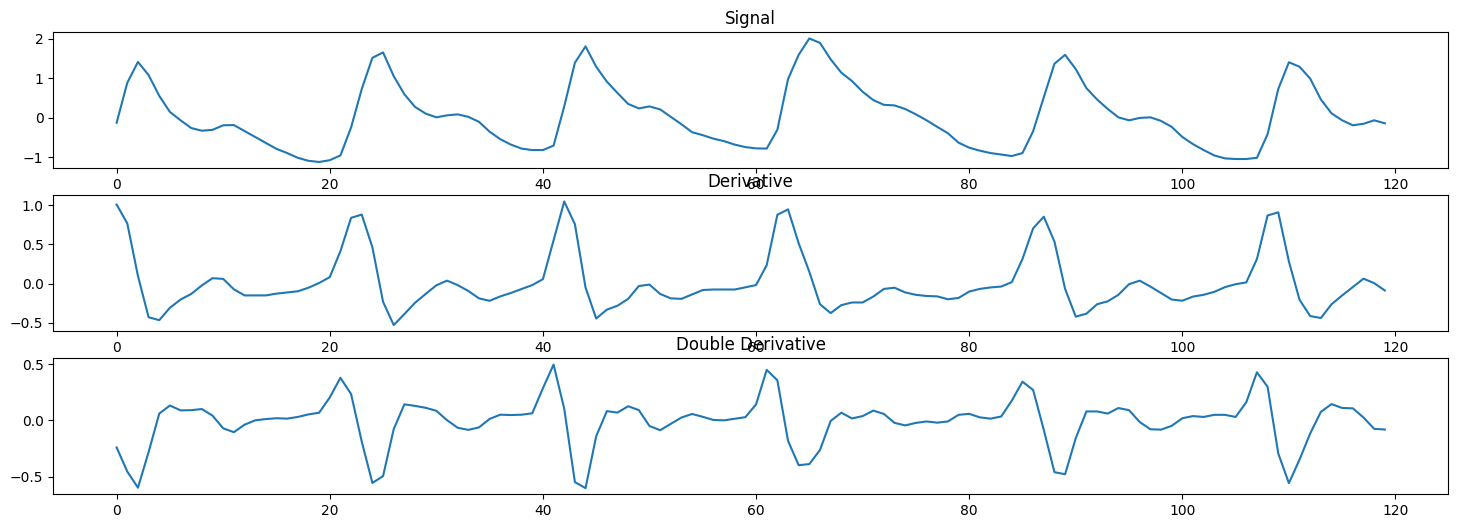

In [4]:
############ Derivatives #############

dydt = np.gradient(bvp_repo[-11])
d2ydt2 = np.gradient(dydt)

plt.figure(figsize=(18, 6))
n = 120
plt.subplot(3, 1, 1)
plt.plot(bvp_repo[-11][:n])
plt.title(f'Signal')

plt.subplot(3, 1, 2)
plt.plot(dydt[:n])
plt.title(f'Derivative')

plt.subplot(3, 1, 3)
plt.plot(d2ydt2[:n])
plt.title(f'Double Derivative')

plt.show()

### Fourier Transform and Band Filtering

In [5]:

idx = 0
order = 4
fs = 60
nyq = 0.5*fs

#band1
lowcut = 0.7
highcut = 4
b, a = scipy.signal.butter(order, [lowcut/nyq, highcut/nyq], btype='band', analog=False)
filtered_sig = scipy.signal.filtfilt(b,a, bvp_repo[idx])

#band2
lowcut = 4
highcut = 10
b, a = scipy.signal.butter(order, [lowcut/nyq, highcut/nyq], btype='band', analog=False)
notch_sig = scipy.signal.filtfilt(b,a, bvp_repo[idx])


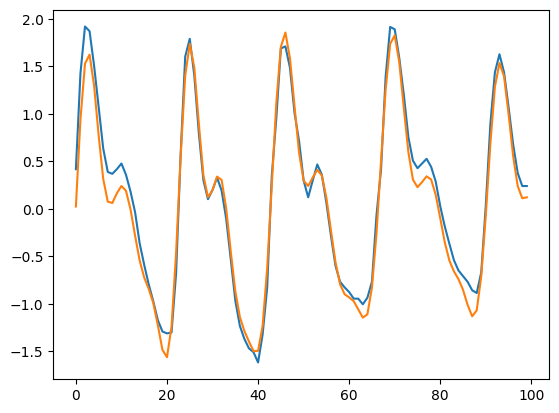

In [6]:

plt.plot(bvp_repo[idx][:100])
plt.plot(filtered_sig[:100] + notch_sig[:100])
plt.show()

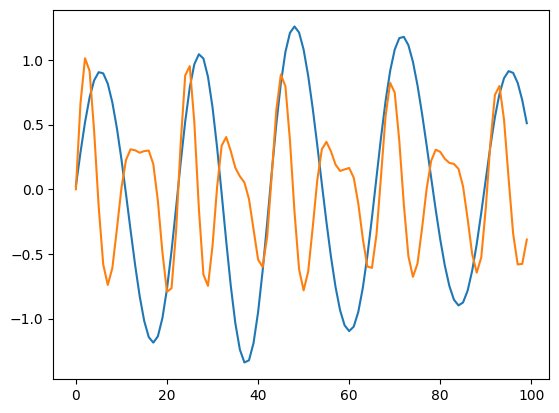

In [7]:
plt.plot(filtered_sig[:100])
plt.plot(notch_sig[:100])

plt.show()

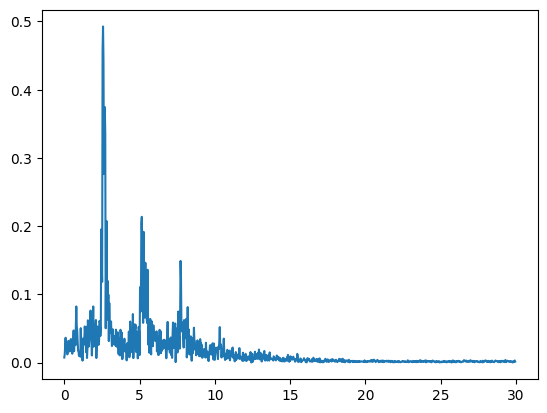

In [8]:

############ FFT ##############
psd = fft(bvp_repo[idx])
psd = 2.0/N * np.abs(psd[0:N//2])

freq = fftfreq(N, d=1/fs) 
freq = freq[0:N//2] # Only take the positive frequencies

plt.plot(freq, psd)
plt.show()

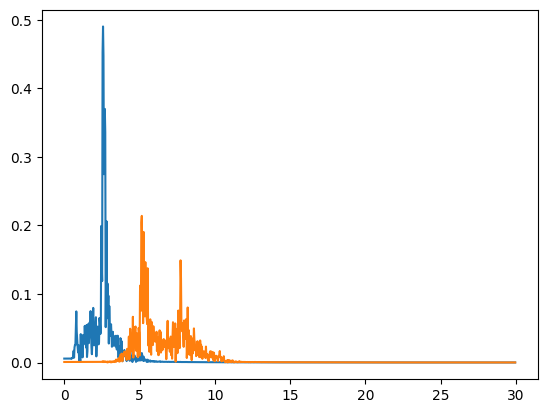

In [9]:
psd_low = fft(filtered_sig)
psd_high = fft(notch_sig)
psd_low = 2.0/N * np.abs(psd_low[0:N//2])
psd_high = 2.0/N * np.abs(psd_high[0:N//2])

freq = fftfreq(N, d=1/fs) 
freq = freq[0:N//2] # Only take the positive frequencies

plt.plot(freq, psd_low)
plt.plot(freq, psd_high)
plt.show()

In [24]:
peaks, _ = scipy.signal.find_peaks(psd, prominence=0.2)
peak_freqs = freq[peaks]
peak_freqs


array([2.57523434, 5.15046867])

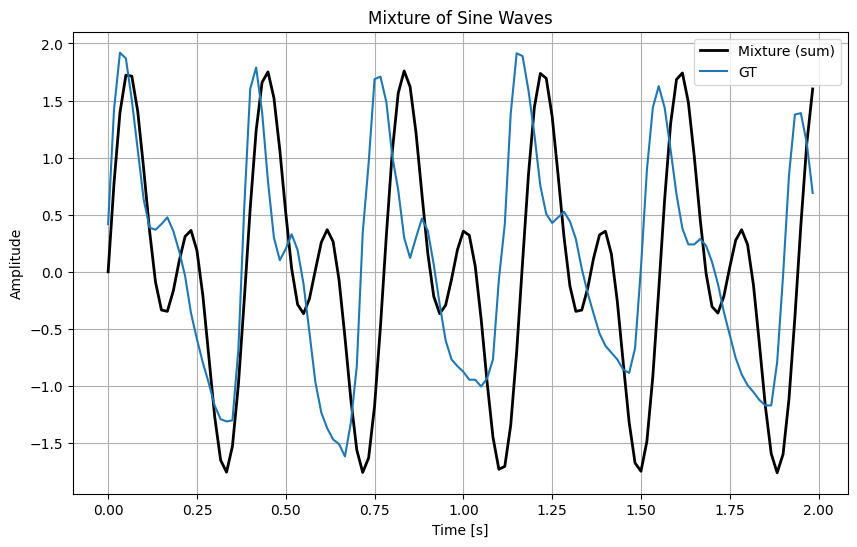

In [30]:
# Sampling settings
fs = 60  # Sampling frequency (Hz)
duration = 2.0  # seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Generate sine waves and sum them
signals = [np.sin(2 * np.pi * f * t) for f in peak_freqs]
mixture = np.sum(signals, axis=0)

# Plot
plt.figure(figsize=(10, 6))
# for i, sig in enumerate(signals):
#     plt.plot(t, sig, label=f"{peak_freqs[i]} Hz")

plt.plot(t, mixture, 'k', linewidth=2, label="Mixture (sum)")
plt.plot(t, bvp_repo[idx][:120], label='GT')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Mixture of Sine Waves")
plt.legend()
plt.grid(True)
plt.show()


### Periodogram

In [53]:
from scipy.signal import spectrogram

# bvp: your BVP signal array
# fs: sampling frequency in Hz

f, t, Sxx = spectrogram(bvp_repo[idx][:2400], fs)
Sxx.shape

(129, 8)

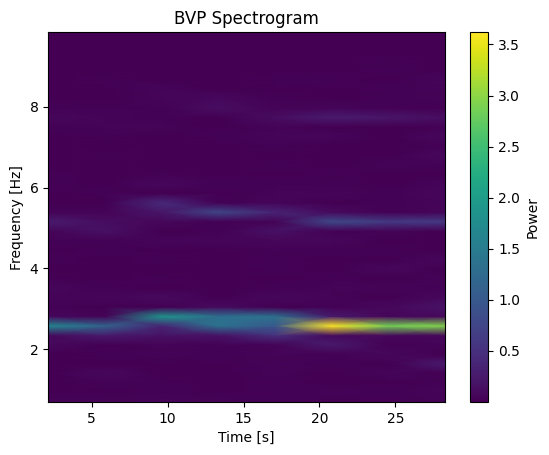

In [69]:
mask = (f >= 0.5) & (f <= 10)
f_limited = f[mask]
Sxx_limited = Sxx[mask, :]


plt.pcolormesh(t, f_limited, Sxx_limited, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('BVP Spectrogram')
plt.colorbar(label='Power')
plt.show()


In [89]:
top_n = 2
# sorted_idxs = np.argsort(Sxx_limited, axis=0)  # ascending order
# peak_idxs = sorted_idxs[-top_n:]  # top 2 peaks, shape (2, num_time_bins)
peak_idxs = []
for i in range(Sxx_limited.shape[1]):
    peaks, _  = scipy.signal.find_peaks(Sxx_limited[:, i], prominence=0.1, distance = 10)
    peak_idxs.append(peaks[:2]) 
peak_idxs = np.array(peak_idxs).T
peak_freqs = f_limited[peak_idxs]
peak_amps = np.sqrt(Sxx_limited[peak_idxs, np.arange(Sxx_limited.shape[1])])
peak_idxs

array([[ 8,  8,  9,  8,  9,  8,  8,  8],
       [19, 18, 21, 20, 20, 19, 19, 19]])

In [90]:

# Reconstruct signal
reconstructed = np.zeros_like(bvp_repo[idx])  # full length match

window_len = int(np.diff(t[:2])[0] * fs)  # samples per spectrogram window

for i in range(len(t)):
    start = int(t[i] * fs)
    end = min(start + window_len, len(bvp_repo[idx]))
    print(f"i={i}, start={start}, end={end}, end-start={end-start}")
    if end <= start:
        continue
    ts = np.arange(start, end) / fs
    for peak in range(top_n):
        freq = peak_freqs[peak, i]
        amp = peak_amps[peak, i]
        print(f"time idx {i}: freq={freq:.3f}, amp={amp:.3f}, ts len={len(ts)}")
        reconstructed[start:end] += amp * np.sin(2 * np.pi * freq * ts)

i=0, start=128, end=351, end-start=223
time idx 0: freq=2.578, amp=1.300, ts len=223
time idx 0: freq=5.156, amp=0.525, ts len=223
i=1, start=352, end=575, end-start=223
time idx 1: freq=2.578, amp=1.066, ts len=223
time idx 1: freq=4.922, amp=0.398, ts len=223
i=2, start=576, end=799, end-start=223
time idx 2: freq=2.812, amp=1.373, ts len=223
time idx 2: freq=5.625, amp=0.658, ts len=223
i=3, start=800, end=1023, end-start=223
time idx 3: freq=2.578, amp=1.161, ts len=223
time idx 3: freq=5.391, amp=0.878, ts len=223
i=4, start=1024, end=1247, end-start=223
time idx 4: freq=2.812, amp=1.159, ts len=223
time idx 4: freq=5.391, amp=0.595, ts len=223
i=5, start=1248, end=1471, end-start=223
time idx 5: freq=2.578, amp=1.903, ts len=223
time idx 5: freq=5.156, amp=0.904, ts len=223
i=6, start=1472, end=1695, end-start=223
time idx 6: freq=2.578, amp=1.688, ts len=223
time idx 6: freq=5.156, amp=0.780, ts len=223
i=7, start=1696, end=1919, end-start=223
time idx 7: freq=2.578, amp=1.715, 

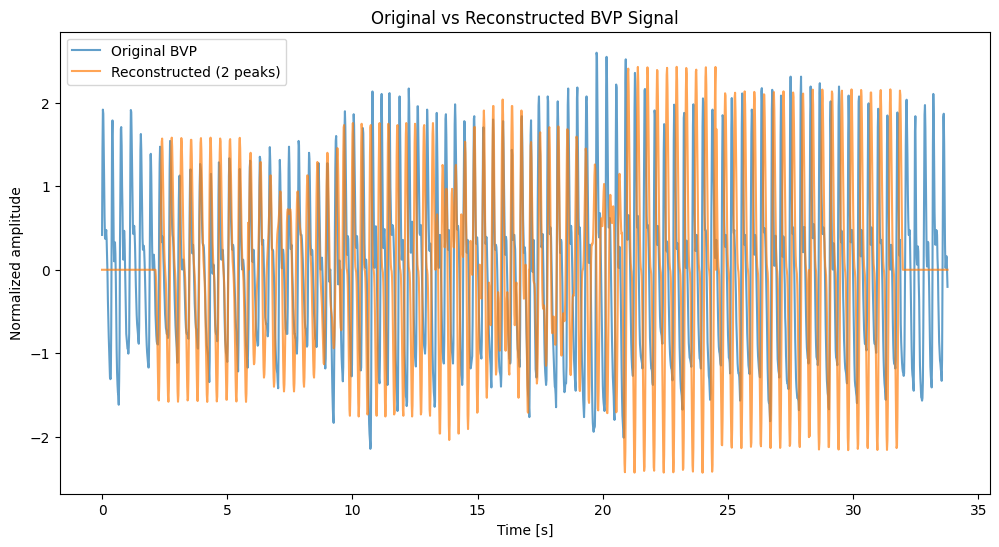

In [93]:

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(bvp_repo[idx])) / fs, bvp_repo[idx], label="Original BVP", alpha=0.7)
plt.plot(np.arange(len(reconstructed)) / fs, reconstructed, label="Reconstructed (2 peaks)", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Normalized amplitude")
plt.legend()
plt.title("Original vs Reconstructed BVP Signal")
plt.show()

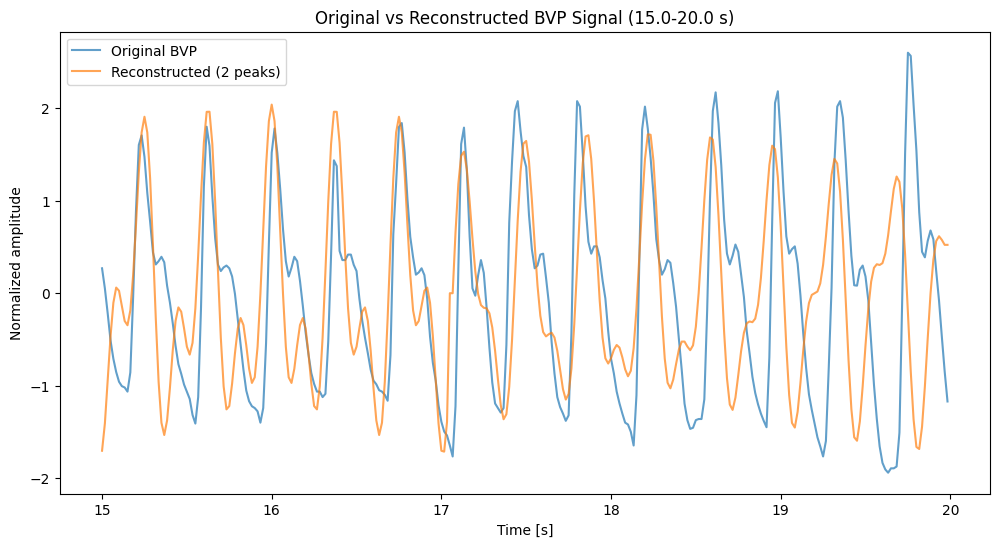

In [94]:
start_time = 15.0  # seconds
end_time = 20.0   # seconds

# Convert to sample indices
start_idx = int(start_time * fs)
end_idx = int(end_time * fs)

# Slice time axis and signals
time_axis = np.arange(len(bvp_repo[idx])) / fs
time_slice = time_axis[start_idx:end_idx]
bvp_slice = bvp_repo[idx][start_idx:end_idx]
reconstructed_slice = reconstructed[start_idx:end_idx]

plt.figure(figsize=(12, 6))
plt.plot(time_slice, bvp_slice, label="Original BVP", alpha=0.7)
plt.plot(time_slice, reconstructed_slice, label="Reconstructed (2 peaks)", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Normalized amplitude")
plt.legend()
plt.title(f"Original vs Reconstructed BVP Signal ({start_time}-{end_time} s)")
plt.show()


### Others

In [6]:
############ EMD ##############

# emd = EMD()
# IMFs = emd(dydt)

# # Plot IMFs
# plt.figure(figsize=(12, 6))
# for i, imf in enumerate(IMFs):
#     plt.subplot(len(IMFs), 1, i+1)
#     plt.plot(imf[:300])
#     plt.title(f'IMF {i+1}')
# plt.tight_layout()
# plt.show()

############## VMD ################

# alpha = 60         # moderate bandwidth constraint
# tau = 0.5          # noise-tolerance (no strict fidelity enforcement)
# K = 7              # number of modes (e.g., 3 modes)
# DC = 0             # no DC component
# init = 1           # initialize omegas uniformly
# tol = 1e-5

# u, _, _ = VMD(bvp_repo[0], alpha, tau, K, DC, init, tol)

# # u: K x len(signal)
# # Plot modes
# plt.figure(figsize=(12, 6))
# for i in range(K):
#     plt.subplot(K, 1, i+1)
#     plt.plot(u[i][:300])
#     plt.title(f'VMD Mode {i+1}')
# plt.show()